## **TDMA Method**

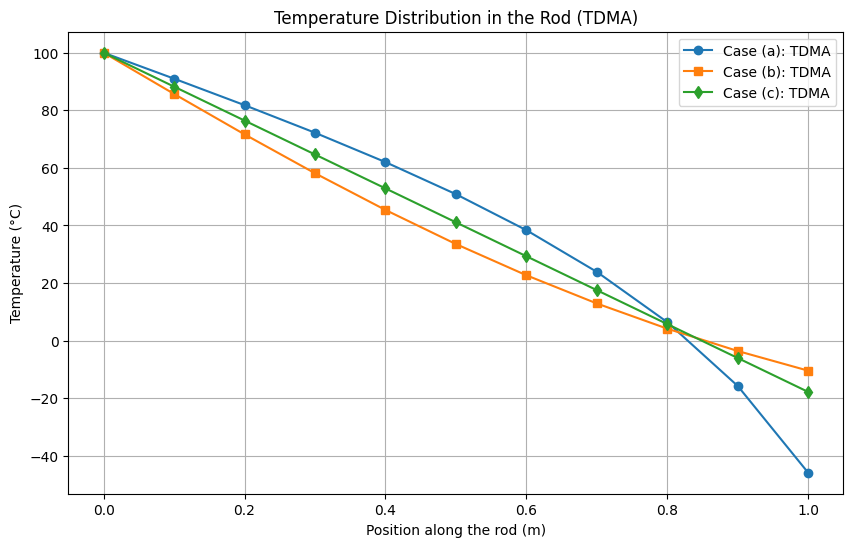

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Problem parameters
L = 1.0  # Length of the rod in meters
N = 10  # Number of divisions
dx = L / N  # Step size
T0 = 100  # Temperature at the left end (°C)
h = 10  # Heat transfer coefficient (W/m^2K)
Tf = 25  # Fluid temperature (°C)
k0 = 1  # Thermal conductivity at x=0 (W/mK)

# Discretization: Central difference scheme
x = np.linspace(0, L, N+1)

# Case (a): k(x) = k0 * (1 - x^2/2)
k_a = k0 * (1 - x**2 / 2)

# Case (b): k(x) = k0 * (1 + x^2/2)
k_b = k0 * (1 + x**2 / 2)

# Case (c): k(x) = k0 (constant)
k_c = k0 * np.ones_like(x)

# Coefficient matrix setup
def setup_matrix(k, dx, h, N):
    A = np.zeros((N+1, N+1))
    b = np.zeros(N+1)

    # Left boundary condition
    A[0, 0] = 1.0
    b[0] = T0

    # Internal nodes
    for i in range(1, N):
        A[i, i-1] = k[i-1] / dx**2
        A[i, i] = -(k[i+1] + k[i-1]) / dx**2
        A[i, i+1] = k[i+1] / dx**2

    # Right boundary condition (convection)
    A[N, N-1] = k[N-1] / dx**2
    A[N, N] = -(k[N] / dx + h)
    b[N] = -h * Tf

    return A, b

# Solving the system using TDMA
def tdma(A, b):
    N = len(b)
    x = np.zeros(N)
    c_star = np.zeros(N)
    d_star = np.zeros(N)

    # Forward elimination
    c_star[0] = A[0, 1] / A[0, 0]
    d_star[0] = b[0] / A[0, 0]

    for i in range(1, N-1):
        c_star[i] = A[i, i+1] / (A[i, i] - A[i, i-1] * c_star[i-1])
        d_star[i] = (b[i] - A[i, i-1] * d_star[i-1]) / (A[i, i] - A[i, i-1] * c_star[i-1])

    d_star[N-1] = (b[N-1] - A[N-1, N-2] * d_star[N-2]) / (A[N-1, N-1] - A[N-1, N-2] * c_star[N-2])

    # Back substitution
    x[N-1] = d_star[N-1]

    for i in range(N-2, -1, -1):
        x[i] = d_star[i] - c_star[i] * x[i+1]

    return x

# Case (a)
A_a, b_a = setup_matrix(k_a, dx, h, N)
T_a_tdma = tdma(A_a, b_a)

# Case (b)
A_b, b_b = setup_matrix(k_b, dx, h, N)
T_b_tdma = tdma(A_b, b_b)

# Case (c)
A_c, b_c = setup_matrix(k_c, dx, h, N)
T_c_tdma = tdma(A_c, b_c)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x, T_a_tdma, 'o-', label='Case (a): TDMA')
plt.plot(x, T_b_tdma, 's-', label='Case (b): TDMA')
plt.plot(x, T_c_tdma, 'd-', label='Case (c): TDMA')
plt.xlabel('Position along the rod (m)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Distribution in the Rod (TDMA)')
plt.legend()
plt.grid(True)
plt.show()


# **Gauss Seidel Method**

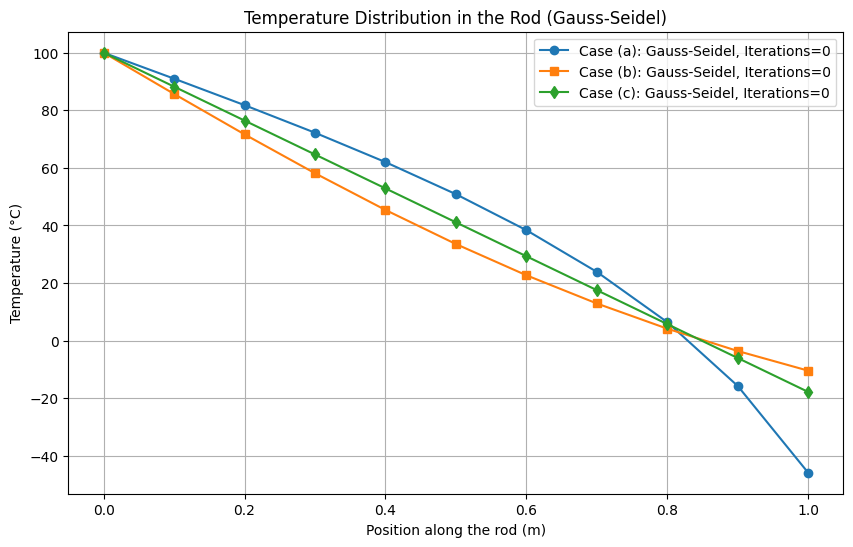

(array([100.        ,  90.98507521,  81.78617236,  72.20197515,
         61.9927216 ,  50.85005059,  38.34851725,  23.85998524,
          6.38852017, -15.781154  , -45.93191087]),
 array([100.        ,  85.67573968,  71.63234721,  58.12650087,
         45.37097932,  33.52251708,  22.67816181,  12.8790456 ,
          4.1192296 ,  -3.64302729, -10.47381334]),
 array([100.        ,  88.21428571,  76.42857143,  64.64285714,
         52.85714286,  41.07142857,  29.28571429,  17.5       ,
          5.71428571,  -6.07142857, -17.85714286]),
 0,
 0,
 0)

In [3]:
#Gauss-Seidel with an initial guess closer to the expected solution
def gauss_seidel(A, b, initial_guess=None, tol=1e-6, max_iterations=10000):
    N = len(b)
    T = np.zeros(N) if initial_guess is None else initial_guess
    iterations = 0

    for _ in range(max_iterations):
        T_old = T.copy()
        for i in range(N):
            sum1 = np.dot(A[i, :i], T[:i])
            sum2 = np.dot(A[i, i+1:], T[i+1:])
            T[i] = (b[i] - sum1 - sum2) / A[i, i]

        # Check for convergence
        if np.linalg.norm(T - T_old, ord=np.inf) < tol:
            break
        iterations += 1

    return T, iterations

# Use TDMA results as initial guess for convergence
T_initial_guess_a = T_a_tdma.copy()
T_initial_guess_b = T_b_tdma.copy()
T_initial_guess_c = T_c_tdma.copy()

# Case (a) - Gauss-Seidel
T_a_gs, iterations_a = gauss_seidel(A_a, b_a, initial_guess=T_initial_guess_a)

# Case (b) - Gauss-Seidel
T_b_gs, iterations_b = gauss_seidel(A_b, b_b, initial_guess=T_initial_guess_b)

# Case (c) - Gauss-Seidel
T_c_gs, iterations_c = gauss_seidel(A_c, b_c, initial_guess=T_initial_guess_c)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x, T_a_gs, 'o-', label=f'Case (a): Gauss-Seidel, Iterations={iterations_a}')
plt.plot(x, T_b_gs, 's-', label=f'Case (b): Gauss-Seidel, Iterations={iterations_b}')
plt.plot(x, T_c_gs, 'd-', label=f'Case (c): Gauss-Seidel, Iterations={iterations_c}')
plt.xlabel('Position along the rod (m)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Distribution in the Rod (Gauss-Seidel)')
plt.legend()
plt.grid(True)
plt.show()

T_a_gs, T_b_gs, T_c_gs, iterations_a, iterations_b, iterations_c
